Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [13]:
NAME = "David Pešek"
COLLABORATORS = ""

---

# Assignment: Analyzing Wikipedia Pages

In this assignment, you will analyze a small fraction of [Wikipedia](https://en.wikipedia.org/wiki/Main_Page) pages. For manipulating Wikipedia pages, you will use `pywikibot` module, which could require an installation. You can install the module in several ways; it depends on your installation of Python and Jupyter. If you have administrator rights, you can use
```
pip install pywikibot
```
You can call it directly from the notebook:

```
!pip install pywikibot
```
Official documentation for the `pywikibot` module can be found [here](https://doc.wikimedia.org/pywikibot/stable/).

In [14]:
import pywikibot as pw
import networkx as nx
import numpy as np
from pprint import pprint

The `pywikibot` module enables us to load Wikipedia pages and extract links contained within them. E.g., let us download the page about the beetle [Bembidion Ambiguum](https://en.wikipedia.org/wiki/Bembidion_ambiguum) 

![Bembidion ambiguum from Wikipedia](https://upload.wikimedia.org/wikipedia/commons/thumb/0/06/Bembidion_ambiguum.jpg/193px-Bembidion_ambiguum.jpg)

Let us list all the links on the page.

In [15]:
name = "Bembidion ambiguum"
# Wikipedia is in many languages. Let us examine the Spanish version of the page on Bembidion ambiguum.
page = pw.Page(pw.Site('es'), name)

linkedpages_list = []
for lp in page.linkedPages():
    linkedpages_list.append(lp.title())
    
print(f"The Wikipedia page on '{name}' has the title '{page.title()}' and contains {len(linkedpages_list)} links:")
print("\n".join(linkedpages_list))

The Wikipedia page on 'Bembidion ambiguum' has the title 'Bembidion ambiguum' and contains 21 links:
Animalia
Arthropoda
Bembidion
BugGuide
Carabidae
Catalogue of Life
Clase (biología)
Coleoptera
Control de autoridades
Especie
Familia (biología)
Filo
Global Biodiversity Information Facility
Género (biología)
Insecta
Orden (biología)
Reino (biología)
Taxonomía
Wikidata
Wikimedia Commons
Wikispecies


In [16]:
name = "Bembidion ambiguum"
# Now the same subject, but on English Wikipedia
page = pw.Page(pw.Site('en'), name)

linkedpages_list = []
for lp in page.linkedPages():
    linkedpages_list.append(lp.title())
    
print(f"The Wikipedia page on '{name}' has the title '{page.title()}' and contains {len(linkedpages_list)} links:")
print("\n".join(linkedpages_list))

The Wikipedia page on 'Bembidion ambiguum' has the title 'Bembidion ambiguum' and contains 27 links:
Adephaga
Animal
Arthropod
Beetle
Bembidion
Binomial nomenclature
California
Doi (identifier)
Global Biodiversity Information Facility
Ground beetle
INaturalist
Insect
Mediterranean region
Open Tree of Life
PMC (identifier)
PMID (identifier)
Pierre François Marie Auguste Dejean
Salt marsh
San Francisco Bay
Taxonomy (biology)
Wikidata
Wikispecies
Wikipedia:Stub
Template:Bembidion-stub
Template:Taxonomy/Bembidion
Template talk:Bembidion-stub
Help:Taxon identifiers


We can also extract pages that refer to the page "Bembidion ambiguum".

In [17]:
references_list = []
for item_reflink in page.getReferences():
    references_list.append(item_reflink.title())

print(f"There are {len(references_list)} pages linking to the page '{name}':")
print("\n".join(references_list))

There are 3 pages linking to the page 'Bembidion ambiguum':
List of Bembidion species
Wikipedia:WikiProject Academic Journals/Journals cited by Wikipedia/B61
Talk:Bembidion ambiguum


## Constructing ego networks

Our goal will be to analyze a notion by downloading a Wikipedia page, constructing and analyzing the so-called ego network around the given notion.

Initially, build the ego network, a subgraph of nodes directly connected to the node representing the given notion. Then, you will analyze the network.

Your task is to implement three functions and then use them to analyze given notions.

The first function 
```
get_ego_network(ego, lang='en')
```
builds a **directed** ego network around the page with the title `ego` in the language `lang`. The ego network should contain all neighbors of the `ego` page and all links among them:
* the `ego` node,
* all nodes corresponding to Wikipedia pages referred to in the `ego` page, 
* all nodes corresponding to Wikipedia pages that refer to the `ego` page, and
* all (directed) edges among the nodes.

Hence, if a page from the ego network contains a link to a Wikipedia page not contained in the ego network, the link is ignored.

Your implementation should **omit** 
* pages with titles containing the suffix "(identifier)" or "(Identifier)",
* pages with titles containing the colon `:` (e.g., "Template:Taxonomy/Bembidion"),
* self-loops (e.g., "Bembidion ambiguum" in the pages referencing the page "'Bembidion ambiguum'").


**Hint:** Some pages are linked from **huge** number of other Wikipedia pages. Use `getRefences()` carefully! 

In [18]:
def check_link(source, target):
    suffix1 = "(identifier)"
    suffix2 = "(Identifier)"
    colon = ":"
    if target.endswith(suffix1) or target.endswith(suffix2):
        #print("Ignoring identifiers.")
        return False
    if colon in target:
        #print("Ignoring links to other namespaces.")
        return False
    if source == target:
        #print("Ignoring self-loops.")
        return False
    return True
def get_ego_network(ego, lang='en'):
    '''Return ego network - a directed graph of Wikipedia pages - around the 
    page with the title ego.
    '''
    G = nx.DiGraph()
    G.add_node(ego)
    page = pw.Page(pw.Site('en'), ego)
    ## neighbors of ego
    lp_titles_dict = {}
    for lp in page.linkedPages():
        lp_titles_dict[lp.title()] = lp
        if check_link(ego, lp.title()):
            G.add_edge(ego, lp.title())
    for lp in page.getReferences():
        lp_titles_dict[lp.title()] = lp
        if check_link(ego, lp.title()):
            G.add_edge(lp.title(), ego)
    ## iterate through neighbors
    for i,node in enumerate(G.nodes()):
        print(f"Processing node {i+1}/{len(G.nodes())}: {node}")
        if (node == ego):
            continue
        page = lp_titles_dict[node]
        for lp in page.linkedPages():
            if lp.title() in lp_titles_dict:
                if check_link(ego, lp.title()):
                    G.add_edge(node,lp.title())
    return G

The implementation of `get_ego_network` will be tested below, including some hidden tests (**1 point**).

In [19]:

from math import isclose

ego = 'Bembidion ambiguum'
e = get_ego_network(ego)

print("Number of nodes", len(e))
print("Number of edges", len(list(e.edges())))
assert (isclose(len(e), 21, abs_tol=1) and isclose(len(list(e.edges())), 106, rel_tol=0.02)) #or \
        #(isclose(len(e), 23, abs_tol=1) and isclose(len(list(e.edges())), 133, rel_tol=0.02))


Processing node 1/21: Bembidion ambiguum
Processing node 2/21: Adephaga
Processing node 3/21: Animal
Processing node 4/21: Arthropod
Processing node 5/21: Beetle
Processing node 6/21: Bembidion
Processing node 7/21: Binomial nomenclature
Processing node 8/21: California
Processing node 9/21: Global Biodiversity Information Facility
Processing node 10/21: Ground beetle
Processing node 11/21: INaturalist
Processing node 12/21: Insect
Processing node 13/21: Mediterranean region
Processing node 14/21: Open Tree of Life
Processing node 15/21: Pierre François Marie Auguste Dejean
Processing node 16/21: Salt marsh
Processing node 17/21: San Francisco Bay
Processing node 18/21: Taxonomy (biology)
Processing node 19/21: Wikidata
Processing node 20/21: Wikispecies
Processing node 21/21: List of Bembidion species
Number of nodes 21
Number of edges 106


Implement the function
```
get_network(name, lang='en', download=False)
```

that should create the ego-network (directed network of type `nx.DiGraph()`) around the page with the title `name`. If `download` is `True`, the network should be built by downloading pages from Wikipedia, and the built network should be stored as an edge list in the file with the name 
```
name+'.csv'
```
If `download` is `False`, the function will check whether the file with the name `name+'.csv'` exists. If yes, it assumes that 
the file contains the edge-list of the ego network around the notion from the parameter `name`
and returns a network (`nx.DiGraph()`) with the network. Otherwise, it collects the network by calling
the function `get_ego_network(name)` and stores it in the corresponding CSV file, and returns the network.

In [20]:
import os
def get_network(name, lang='en', download=False):
    '''Create the network around the Wikipedia page with the title name. 
    Parameters:
        Name (string)      the title of the page
        download (Boolean) if download is False and a file <name>.csv exists, the network 
                           is read from the file; otherwise, it is built using the function
                           get_ego_network(name) and saved into file <name>.csv
                           as a list of edges.
    Returns:
        An instance of nx.DiGraph() with the ego network around the Wikipedia page name.
    '''
    # YOUR CODE HERE
    filename = f"{name}.csv"
    if download:
        G = get_ego_network(name, lang=lang)
        nx.write_edgelist(G, filename, delimiter=',', data=False)
    else:
        if os.path.exists(filename):
            G = nx.read_edgelist(filename, delimiter=',', create_using=nx.DiGraph())
        else:
            G = get_ego_network(name, lang=lang)
            nx.write_edgelist(G, filename, delimiter=',', data=False)
    return G

The implementation of `get_network` will be tested below, including some hidden tests (**1 point**).

In [ ]:
ego = 'Bembidion ambiguum'

G_Ambiguum = get_network(ego, download=True)


## Analyzing ego networks

Using the above functions (and possibly other suitable functions) implement the following function:

In [30]:
def analyze_ego(G, ego):
    '''Analyze the ego network G with the root node ego.
    '''
    info = {}
    
    # 1. Basic Counts
    n = G.number_of_nodes()
    # Neighbors of ego (nodes in G excluding ego)
    neighbors = [node for node in G.nodes() if node != ego]
    n_neighbors = len(neighbors)
    
    # Degrees
    info['out_degree'] = G.out_degree(ego)
    info['in_degree'] = G.in_degree(ego)
    info['node_num'] = n
    
    # 2. Subgraph for "without ego" metrics
    G_no_ego = G.copy()
    G_no_ego.remove_node(ego)
    
    # Edge num (edges between neighbors only)
    info['edge_num'] = G_no_ego.number_of_edges()
    
    # 3. Densities
    # Max edges = n*(n-1)
    if n > 1:
        info['density'] = nx.density(G)
    else:
        info['density'] = 0.0
        
    if n_neighbors > 1:
        info['density_without_ego'] = nx.density(G_no_ego)
    else:
        info['density_without_ego'] = 0.0
        
    # 4. Centrality and Clustering
    # Betweenness (normalized)
    # Note: nx.betweenness_centrality returns a dict
    bet_dict = nx.betweenness_centrality(G, normalized=True)
    info['betweenness'] = bet_dict[ego]
    
    # Clustering Coefficient
    # nx.clustering for directed graphs matches the formula: 
    # T / (deg*(deg-1) - 2*recip_links)
    info['clustering_coefficient'] = nx.clustering(G, ego)
    
    # 5. Reciprocity Metrics
    # We need to iterate over dyads to calculate these precisely according to the definitions
    nodes = list(G.nodes())
    dyads_total = n * (n - 1) // 2
    
    mut = 0   # Mutual (bidirectional) edges
    asym = 0  # Asymmetric (one-way) edges
    null = 0  # No edges
    
    # Calculate dyad counts
    for i in range(n):
        for j in range(i + 1, n):
            u, v = nodes[i], nodes[j]
            has_uv = G.has_edge(u, v)
            has_vu = G.has_edge(v, u)
            
            if has_uv and has_vu:
                mut += 1
            elif has_uv or has_vu:
                asym += 1
            else:
                null += 1
                
    # Reciprocity: Pairs bidirectional / Pairs connected (in any direction)
    pairs_connected = mut + asym
    if pairs_connected > 0:
        info['reciprocity'] = mut / pairs_connected
    else:
        info['reciprocity'] = 0.0
        
    # Reciprocity Index: Proportion of symmetric dyads (Mutual + Null) / Total Dyads
    if dyads_total > 0:
        info['reciprocity_index'] = (mut + null) / dyads_total
    else:
        info['reciprocity_index'] = 1.0 # Single node is symmetric by default definition
        
    # Garlaschelli and Loffredo's Reciprocity (GL)
    # Efficient Formula: rho = (L_recip - L^2/M) / (L - L^2/M)
    # where L is total edges, L_recip is count of edges involved in mutual links (2 * mut), M is n*(n-1)
    L = G.number_of_edges()
    L_recip = 2 * mut
    M = n * (n - 1)
    
    if M > 0:
        numerator = L_recip - (L**2 / M)
        denominator = L - (L**2 / M)
        if denominator != 0:
            info['gl_reciprocity'] = numerator / denominator
        else:
            info['gl_reciprocity'] = 0.0 # Denom is 0 for empty or fully complete graphs
    else:
        info['gl_reciprocity'] = 0.0

    # 6. Components
    # Weak components without ego
    info['weak_component_num'] = nx.number_weakly_connected_components(G_no_ego)
    
    # Strong components with ego (whole network)
    info['strong_component_num'] = nx.number_strongly_connected_components(G)
    
    # 7. Brokerage
    # Ego is a broker between u and v if path exists in G, but NOT in G_no_ego
    # We check all ordered pairs of neighbors (u, v)
    brokerage_count = 0
    neighbor_pairs_count = n_neighbors * (n_neighbors - 1)
    
    # Pre-calculate reachability to save time
    # This is O(N * (N+E)), acceptable for ego networks usually
    if n_neighbors > 1:
        # Reachability in G (whole network)
        # We only care about paths between neighbors
        
        # Reachability in G_no_ego
        # We can use shortest_path_length or has_path. 
        # Since we need lengths later for avg_distance, let's compute all lengths in G now.
        
        # All pairs shortest paths in G
        try:
            length_G = dict(nx.all_pairs_shortest_path_length(G))
        except:
            length_G = {} # Should not fail
            
        # All pairs shortest paths in G_no_ego
        try:
            # We use this to check existence of path without ego
            length_G_no_ego = dict(nx.all_pairs_shortest_path_length(G_no_ego))
        except:
            length_G_no_ego = {}

        path_sum = 0
        valid_paths = 0
        infinite_dist_found = False
        
        for u in neighbors:
            for v in neighbors:
                if u == v:
                    continue
                
                # --- Brokerage Check ---
                connected_in_G = (v in length_G.get(u, {}))
                connected_in_G_no_ego = (v in length_G_no_ego.get(u, {}))
                
                if connected_in_G and not connected_in_G_no_ego:
                    brokerage_count += 1
                
                # --- Avg Distance Check ---
                if connected_in_G:
                    path_sum += length_G[u][v]
                    valid_paths += 1
                else:
                    infinite_dist_found = True
        
        info['brokerage'] = brokerage_count
        info['avg_brokerage'] = brokerage_count / neighbor_pairs_count if neighbor_pairs_count > 0 else 0.0
        
        # Avg Distance result
        if infinite_dist_found:
            info['avg_distance'] = float('inf')
        elif valid_paths > 0:
            info['avg_distance'] = path_sum / valid_paths
        else:
            info['avg_distance'] = 0.0 # No pairs?
            
    else:
        # Less than 2 neighbors
        info['brokerage'] = 0
        info['avg_brokerage'] = 0.0
        info['avg_distance'] = 0.0 if n_neighbors < 2 else float('inf')

    # 8. Diameter
    # "if there are two nodes between which there is no oriented path... value should be float('inf')"
    # This implies checking strong connectivity or all-pairs reachability
    if nx.is_strongly_connected(G):
        info['diameter'] = nx.diameter(G)
    else:
        # Even if not strongly connected, diameter might be defined as max eccentricity of *connected* pairs 
        # BUT the prompt explicitly says "if no oriented path... float('inf')"
        # We must check if ANY pair is unreachable.
        # Since we already computed lengths for neighbors, we need to check ALL nodes including ego.
        
        # If n is small, this is fast:
        all_reachable = True
        max_dist = 0
        
        # We can reuse length_G if we add ego to it (length_G currently has all nodes as sources)
        # nx.all_pairs_shortest_path_length returns iterator for all nodes in G usually
        # Let's regenerate to be safe and cover ego:
        lengths = dict(nx.all_pairs_shortest_path_length(G))
        
        for u in G.nodes():
            for v in G.nodes():
                if u == v: continue
                if v not in lengths.get(u, {}):
                    all_reachable = False
                    break
                else:
                    d = lengths[u][v]
                    if d > max_dist:
                        max_dist = d
            if not all_reachable:
                break
        
        if all_reachable:
            info['diameter'] = max_dist
        else:
            info['diameter'] = float('inf')

    return info

The parameters of the function `analyze_ego` are the ego network `G` around node `ego`, i.e., all nodes directly reachable from `ego` and the `ego` node itself. The function returns a dictionary containing values with the following keys:
* `out_degree`: the out-degree of the ego node,
  
* `in_degree`: the in-degree of the ego node (in the ego network only),
  
* `node_num`: the number of nodes in the ego network (including the ego),
  
* `edge_num`: the number of edges between the neighbors of the ego (without edges from or to the ego),
  
* `density`: the ratio of the number of edges in the whole ego network (including the ego node) and the maximal possible number of edges in the whole ego network,
  
* `density_without_ego`: the ratio of the number of edges in the ego network without the ego and the maximal possible number of edges in the ego network without the ego,
  
* `betweenness`: the value of the normalized betweenness centrality for the `ego` node,
  
* `clustering_coefficient`: the fraction of all possible directed triangles $$\frac{T(\texttt{ego})}{deg(\texttt{ego})(deg(\texttt{ego})-1) - 2deg^{\leftrightarrow}(\texttt{ego})},$$ where $T(\texttt{ego})$ is the number of directed triangles through the node ego, $deg(\texttt{ego})$ is the sum of in-degree and out-degree of ego, and $deg^{\leftrightarrow}(\texttt{ego})$ is the number nodes $v$ such that the network contains both edges (ego,$v$) and ($v$, ego),
  
* `reciprocity`: the ratio of the number of links pointing in both directions in the set of all edges of the ego network (including node `ego`) -- more precisely: the number of pairs of nodes connected bidirectionally divided with the number of pairs of nodes that are connected in any direction; thus, it is a value between 0 and 1,

* `reciprocity_index`: the proportion of symmetric dyads in the network; a dyad (a pair of nodes) is symmetric if there is no edge between them or if there are two edges connecting them in both directions,
  
* `gl_reciprocity`: the Garlaschelli and Loffredo's variant of reciprocity introduced in
  >  Diego Garlaschelli; Loffredo, Maria I. (December 2004). "Patterns of Link Reciprocity in Directed Networks". Physical Review Letters. 93 (26). American Physical Society: 268701. arXiv:cond-mat/0404521. Bibcode:2004PhRvL..93z8701G. doi:10.1103/PhysRevLett.93.268701. PMID 15698035. S2CID 1043766.
  
  defined using the adjacency matrix $A=(a_{ij})_{n \times n}$ of a directed network with $n$ nodes ($a_{ij} = 1$
  if  there is an edge $(i,j)$ in the network and $a_{ij}=0$ if not). The Garlaschelli-Loffredo reciprocity is
  $$\rho = \frac{\sum_{i} \sum_{j, j \ne i} \;(a_{ij} - \bar{a}) (a_{ji} - \bar{a})}{\sum_{i}\sum_{j, j \ne i} \; (a_{ij} - \bar{a}) ^ 2},$$
  where $\bar{a}$ denotes the density $$\bar{a} = \frac{\sum_i\sum_{j, j \ne i} a_{ij}}{n(n-1)}.$$
  
  Infer or find a better formula for computing $\rho$ more efficiently than the above formula.
  
* `avg_distance`: the mean of the shortest path lengths among all pairs of the neighbors of the ego (paths between neighbors of ego (different from ego) in the whole ego network); if there are two neighbors $u$, $v$ of ego such that there is no directed path from $u$ to $v$ in the ego network, the resulting value should be float('inf'),

* `diameter`: diameter of the ego network; if there are two nodes between which there is no oriented path in the network, the resulting value should be `float('inf')`,
  
* `weak_component_num`: the number of weak components in the network without the ego node; a weak component is a maximal set (with respect to set inclusion) of nodes that are connected, disregarding the direction of the edges (in contrast, a strong component pays attention to the direction of the edges for directed data); if ego is connected to $A$ and $B$ (which are connected), and ego is connected to $C$ and $D$ (which also are connected), but $A$ and $B$ are not connected in any way to $C$ and $D$ (except by way of everyone being connected to ego) then there would be two "weak components" in ego's neighborhood.

* `strong_component_num`: the number of strong components; a strong component is a maximal set
   (with respect to set inclusion) of mutually connected nodes (directed paths are considered).
  
* `brokerage`: the number of pairs connected with a directed path when the ego node is present
  and not connected when the ego node is missing. The ego is a broker if 
  it is "between" a pair of nodes that, without the ego, would not be connected.
  
* `avg_brokerage`: the normalized brokerage (brokerage divided by the number of pairs);
  it assesses the extent to which the ego's role is that of the broker.

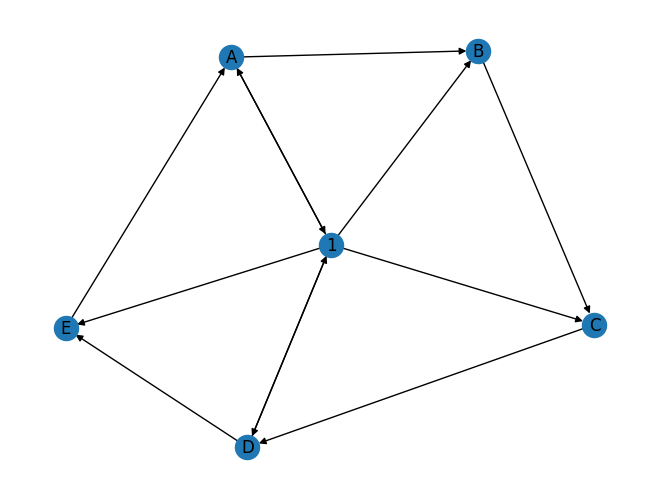

In [31]:
e1 = nx.DiGraph()
e1.add_edges_from([('1','A'), ('1','B'), ('1','C'), ('1','D'), ('1','E'),
                   ('A','1'), ('A','B'),  
                   ('B','C'),
                   ('C','D'),
                   ('D','1'), ('D','E'),
                   ('E','A')])
pos = nx.spring_layout(e1, seed=42)
nx.draw(e1, pos=pos, with_labels=True)

In [ ]:
a = analyze_ego(e1, '1')
pprint(a)

from math import isclose

assert a['out_degree'] == 5
assert a['in_degree'] == 2
assert a['node_num'] == 6
assert a['edge_num'] == 5
assert a['density'] == 0.4 
assert a['density_without_ego'] == 0.25 
assert isclose(a['clustering_coefficient'], 0.2368421052631)
assert isclose(a['reciprocity'],0.2) 
assert isclose(a['reciprocity_index'],0.4666666666666667) 
assert isclose(a['gl_reciprocity'], -0.1111111111111111) 
assert isclose(a['betweenness'], 0.425) 
assert isclose(a['avg_distance'], 2.1) 
assert isclose(a['diameter'], 4) 
assert a['weak_component_num'], 1 
assert a['strong_component_num'], 1 
assert a['brokerage'] == 0 
assert a['avg_brokerage'] == 0

{'avg_brokerage': 0.0,
 'avg_distance': 2.1,
 'betweenness': 0.42500000000000004,
 'brokerage': 0,
 'clustering_coefficient': 0.23684210526315788,
 'density': 0.4,
 'density_without_ego': 0.25,
 'diameter': 4,
 'edge_num': 5,
 'gl_reciprocity': -0.11111111111111108,
 'in_degree': 2,
 'node_num': 6,
 'out_degree': 5,
 'reciprocity': 0.2,
 'reciprocity_index': 0.4666666666666667,
 'strong_component_num': 1,
 'weak_component_num': 1}


AssertionError: 

In [ ]:

e2 = nx.DiGraph()
e2.add_edges_from([('1','A'), ('1','B'), ('1','C'), ('1','D'),
                   ('A','B'),  
                   ('B','C'),
                   ('C','A'),
                   ('D','1'), ('D','E'),
                   ('E','D'), ('E','1')])
pos = nx.spring_layout(e2, seed=42)
nx.draw(e2, pos=pos, with_labels=True)

In the folowing cell your implementation of the function `analyze_ego` will be tested on the ego network `e2` (**2 points**). 

In [ ]:
a = analyze_ego(e2, '1')
pprint(a)


In the folowing cell you should analyze ego network around `Bembidion ambiguum` (**1 point**). 

In [ ]:
ego = 'Bembidion ambiguum'
G_Ambiguum = get_network(ego, download=True)

results = analyze_ego(G_Ambiguum, ego)
pprint(results)

from math import isclose
assert isclose(results["out_degree"], 19, abs_tol=1)
assert isclose(results["in_degree"], 1, abs_tol=1)
assert isclose(results["node_num"], 21, abs_tol=1)
assert isclose(results["edge_num"], 86, abs_tol=3)
assert isclose(results["density"], 0.2523809523809524, rel_tol=0.01)
assert isclose(results["density_without_ego"], 0.22631578947368422, rel_tol=0.01)
assert isclose(results["clustering_coefficient"], 0.22631578947368422, rel_tol=0.02)
assert isclose(results["reciprocity"], 0.17777777777777778, rel_tol=0.02)


After that, you should use your functions and analyze four ego networks around Wikipedia pages on community detection algorithms in network science:
1. around `Girvan–Newman algorithm`,
2. around `Louvain method`,
3. around `Leiden algorithm`, and 
4. around `Clique percolation method`.

In [ ]:
ego = 'Girvan–Newman algorithm'
G_GN = get_network(ego, download=False)

res_dict = {}
res_dict[ego] = analyze_ego(G_GN, ego)
pprint(res_dict[ego])



In [ ]:
ego = 'Louvain method'
G_Louvain = get_network(ego, download=False)

res_dict[ego] = analyze_ego(G_Louvain, ego)
pprint(res_dict[ego])



In [ ]:
isinstance(res_dict[ego]['out_degree'], int)


In [ ]:
ego = 'Leiden algorithm'
G_Leiden = get_network(ego, download=False)

res_dict[ego] = analyze_ego(G_Leiden, ego)
pprint(res_dict[ego])



In [ ]:
ego = 'Clique percolation method'
G_CPM = get_network(ego, download=False)

res_dict[ego] = analyze_ego(G_CPM, ego)
pprint(res_dict[ego])



Collect the obtained measures in a table.

In [ ]:
# create a table: rows should be collected measures, and columns should be titles of the ego nodes
import pandas as pd

# YOUR CODE HERE
raise NotImplementedError()

Are the networks comparable? Compare the four ego networks according to the obtained results:
* Comment on the found differences and similarities.
* Is it possible to identify which methods are related more strongly than the other?

Write your answer in the cell below (**1 point**).

YOUR ANSWER HERE

## A comparison using neighborhood overlap

To evaluate the strength of a relationship between two nodes, we can also use neighborhood overlap. Neighborhood overlap is a local similarity metric that measures the extent to which the neighborhoods of two nodes overlap. A general Formula is
$$NO(u,v)= \left\{ \begin{array}{ll}
                        \frac{∣N(u)\cap N(v)∣}{∣N(u)\cup N(v)∣} & \text{if } {∣N(u)\cup N(v)∣} \ne \emptyset, \\
                        0                                     & \text{otherwise},
                    \end{array}
           \right.$$
where $N(u)$ and $N(v)$ denote the set of neighbors of nodes $u$ and $v$, respectively. 

In contrast to the lecture, we will consider neighborhood overlap for directed networks. In a directed network $G=(V, E)$, where $V$ is the set of nodes and $E\subseteq V \times V$ is the set of directed edges, each node has:
* *In-neighbors:* nodes with edges pointing to it.
* *Out-neighbors:* nodes it points to.
  
Unlike undirected networks (where "neighbor" is unambiguous), in directed networks, we must specify which type of neighbors we compare:
* $N_{\mathrm{in}}(u) = \{v \mid (v,u) \in E \}$ will denote the set of all in-neighbors.
* $N_{\mathrm{out}}(u) = \{v \mid (u,v) \in E \}$ will denote the set of all out-neighbors.
* $N_{\mathrm{both}}(u) = \{v \mid (v,u) \in E \text{ or } (u,v) \in E\}$ will denote the set of all in- and out-neighbors.
  
Then, we can define the following three types of neighborhood overlap (in all of the formulas below, **if both neighborhoods are empty**, we set the result **0**):
1. **In-Neighbor Overlap** measures the overlap of nodes that point to both $u$ and $v$:
    $$NO_{\mathrm{in}}(u,v)= \frac{∣N_{\mathrm{in}}(u)\cap N_{\mathrm{in}}(v)∣}{∣N_{\mathrm{in}}(u)\cup N_{\mathrm{in}}(v)∣}.$$
2. **Out-Neighbor Overlap** measures the overlap of nodes that both $u$ and $v$ point to:
    $$NO_{\mathrm{out}}(u,v)= \frac{∣N_{\mathrm{out}}(u)\cap N_{\mathrm{out}}(v)∣}{∣N_{\mathrm{out}}(u)\cup N_{\mathrm{out}}(v)∣}.$$
3. **Bidirectional (Combined) Overlap** considers both in- and out-neighbors:
    $$NO_{\mathrm{both}}(u,v)= \frac{∣N_{\mathrm{both}}(u)\cap N_{\mathrm{both}}(v)∣}{∣N_{\mathrm{both}}(u)\cup N_{\mathrm{both}}(v)∣}.$$


Next, implement the following function that can compute any of the above neighborhood overlap type.

In [ ]:
def neighborhood_overlap(G, u, v, neighbor_type='out'):
    # For the directed network G, nodes u and v, return the neighborhood overlap of type neighbor_type.
    if neighbor_type not in ['in', 'out', 'both']:
        raise ValueError("neighbor_type must be 'in', 'out', or 'both'")
    # YOUR CODE HERE
    raise NotImplementedError()

Below, your implementation will be tested including some hidden tests (**1 point**).

In [ ]:
# Example: Out-neighbor overlap between nodes 1 and 2
# Create a directed graph
G = nx.DiGraph()
G.add_edges_from([(1,2), (2,3), (3,1), (3,2), (2,4), (1,4), (2,4)])


assert isclose(neighborhood_overlap(G, 1, 2, neighbor_type='in'), 0.5)
assert isclose(neighborhood_overlap(G, 1, 2, neighbor_type='out'), 0.333333, rel_tol=0.01)
assert isclose(neighborhood_overlap(G, 1, 2, neighbor_type='both'), 0.5)


Now, compute the neighborhood overlap for all pairs of the above community detection methods. Display the computed scores as three heatmaps - one for each type of neighborhood. A heatmap could resemble the following image (note that the values in the image **do not correspond** to the true neighborhood overlap scores).

![Samle heatmap](heatmap_sample.png)



In [ ]:
# YOUR CODE HERE
raise NotImplementedError()




Based on the heatmaps, answer the following questions:
1. Which pair of community detection algorithms is most strongly related? Does it correspond to the full description of the methods?
2. Which type of neighborhood was the most helpful in answering the previous question?
3. In general, for finding similarities and differences between nodes of a network, is it better to use some of the measures implemented in the function `analyze_ego` or the neighborhood overlap implemented above?

Write your answer in the cell below (**1 point**).

YOUR ANSWER HERE

## What to submit

A ZIP file containing:

1. Notebook, where all the questions are answered, and the requested code is filled in.
2. Five CSV files with downloaded networks
3. 1. `Bembidion ambiguum.csv`,
   2. `Girvan–Newman algorithm.csv`,
   3. `Louvain method.csv`,
   4. `Leiden algorithm`,
   5. `Clique percolation method.csv`.